In [0]:
#!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
  
import theano
import theano.tensor as T
import lasagne

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [0]:
from sklearn.metrics import mean_squared_error
  
def estimator_loss(y, y_pred):
    return ((y - y_pred)**2).sum(-1)

class GatingEnsemble:
    
    def __init__(self, estimators, estimator_loss=estimator_loss, n_hidden_units=50,
                loging=False):

        self.estimators = estimators
        self.estimator_loss = estimator_loss
        self.n_hidden_units = n_hidden_units # number of hidden units in gate1
        
        self.regularizer=theano.shared(np.float32(0.5),name='entropy reg',allow_downcast=True)
        self.regularizer_decay=0.99
        self.loging=loging
    
    def log(self, string):
        if self.loging:
          print(string)
    
    def fit(self,X,y,n_iter=500):
        
        self.compile_gf((None,)+X.shape[1:])
        params_vec = []
        k = 0
        for i in range(n_iter):
            self.log("Launched iteration {} of {} ".format(i + 1, n_iter))
            self.refit_estimators(X,y)
            self.refit_gf(X,y,n_iter=10)
            self.regularizer.set_value(self.regularizer_decay*self.regularizer.get_value())
        
    
    def refit_gf(self,X,y,n_iter=7):
        best_estimator_ix = np.argmin([self.estimator_loss(y,est.predict(X))
                                 for est in self.estimators],axis=0).astype('int32')
        
        for i in range(n_iter):
            self.fit_nn_step(X,best_estimator_ix)
        
    def refit_estimators(self,X,y):
        #ix = np.random.randint(0,len(X),size=len(X))
        #X,y = X[ix],y[ix]
        W = self.get_W(X)
        W = (W == np.max(W,axis=1,keepdims=True)).astype('float32')
        W /= W.sum(axis=0,keepdims=True)
        W[np.isnan(W)] = 1./W.shape[1]
        
        # print(W[:1])
        self.estimators = [est.fit(X,y,sample_weight=W[:,i]) for i,est in enumerate(self.estimators)] # fails if estimator has no "sample_weight argument
        
        
        #
        # Вроде пока не нужно, но кто её знает
        # 
        
        # self.get_est_params = [est.get_params() for est in self.estimators]
        
    def build_gating_function(self,x_shape,n_gates):
        
        #Input layer (auxilary)
        input_layer = lasagne.layers.InputLayer(shape = x_shape)

        #fully connected layer, that takes input layer and applies <n_hidden_units> neurons to it.
        # nonlinearity here is sigmoid as in logistic regression
        dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=self.n_hidden_units, W=lasagne.init.Normal(0.01),
                                          nonlinearity = lasagne.nonlinearities.tanh,
                                          name = "hidden_dense_layer")
        
        

        #fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
        #We use softmax nonlinearity to make probabilities add up to 1
        dense_logit = lasagne.layers.DenseLayer(dense_1,num_units = n_gates,
                                                 nonlinearity = None,
                                                 name='output')
        
        dense_logit = lasagne.layers.GaussianNoiseLayer(dense_logit,0.01)
        
        dense_output = lasagne.layers.NonlinearityLayer(dense_logit,T.nnet.softmax)
        return dense_output
    
    def compile_gf(self,x_shape):
        
        input_X = T.matrix("X")
        
        target_W_of_x = T.ivector("W(x) target - probability that i-th estimator is best")
        
        nn = self.nn = self.build_gating_function(x_shape,n_gates=len(self.estimators))
        
        w_predicted = lasagne.layers.get_output(nn,inputs=input_X)
        
        loss = lasagne.objectives.categorical_crossentropy(w_predicted,target_W_of_x).mean()        
        loss += self.regularizer*(w_predicted*T.log(w_predicted)).sum(1).mean() #negative entropy
        
        
        nn_params = lasagne.layers.get_all_params(self.nn,trainable=True)
        
        updates = lasagne.updates.adamax(loss,nn_params)
        
        self.fit_nn_step = theano.function([input_X,target_W_of_x],loss, updates=updates)
        self.get_W = theano.function([input_X], w_predicted)
    
    def predict(self,X):
        W = self.get_W(X)        
        base_predictions = np.stack([est.predict(X) for est in self.estimators],axis=1)    
        return (W[:,:,None]*base_predictions).sum(axis=1)

In [0]:
import scipy.stats as sps

def generate_circle(x0, y0, r, n_points, noise_sigma):
    noise_generator = sps.norm(scale=noise_sigma)
    t = np.linspace(0, 2 * np.pi, n_points)
    x = x0 + r * np.cos(t) + noise_generator.rvs(size=n_points)
    y = y0 + r * np.sin(t) + noise_generator.rvs(size=n_points)
    return x, y

def calc_X_y_matrices(x, y):
  A = np.vstack((2 * x, 2 * y, np.ones(len(x)))).T
  B = x ** 2 + y ** 2
  B = B.reshape(-1, 1)
  return A, B

def visualize_circle(x0, y0, r):
  x, y = generate_circle(x0, y0, r, 1000, 0)
  plt.plot(x, y)

def get_circle_params_from_lr(lr):
  c1, c2, c3 = lr.coef_[0]
  x0 = c1
  y0 = c2
  r  = np.sqrt(c3 + c2 ** 2 + c1 ** 2)
  return x0, y0, r

In [0]:
from sklearn.linear_model import LinearRegression

x1, y1 = generate_circle(0, 0, 1, 50, 0.1)
x2, y2 = generate_circle(0, 0, 2, 50, 0.1)
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

gf = GatingEnsemble([LinearRegression(fit_intercept=False) for i in range(2)])
gf.fit(*calc_X_y_matrices(x, y), n_iter=10000)

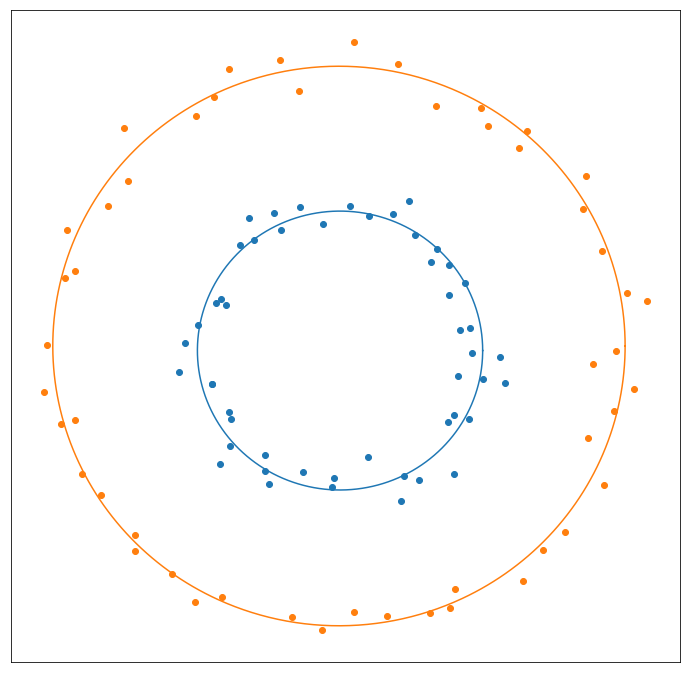

In [21]:
plt.figure(figsize=(12, 12))

visualize_circle(*get_circle_params_from_lr(gf.estimators[1]))
plt.scatter(x1, y1)

visualize_circle(*get_circle_params_from_lr(gf.estimators[0]))
plt.scatter(x2, y2)

plt.xticks([])
plt.yticks([])

plt.show()